## Iso-mirror analysis on the FinDKG data

First, we import the library `dmprdpg`.

In [19]:
import dmprdpg

In [20]:
import matplotlib.pyplot as plt
## Compile with tikz and times font
plt.rc('text', usetex=True)
plt.rc('font', family='times')

Next, import the FinDKG data and related mapping files. 

In [21]:
import pandas as pd
import numpy as np

# Load the dataframe from the .txt file
df = pd.read_csv('../data/FinDKG-full/findkg.txt', sep='\t', header=None)
df.columns = ['Source Entity', 'Relation', 'Target Entity', 'Timestamp', 'Zero']
map_entity = pd.read_csv('../data/FinDKG-full/entity2id.txt', sep='\t', header=None)
map_relation = pd.read_csv('../data/FinDKG-full/relation2id.txt', sep='\t', header=None)
map_times = pd.read_csv('../data/FinDKG-full/time2id.txt', sep='\t', header=None)

# Print the number of rows and columns
N = len(map_entity)
K = len(map_relation)

In [22]:
## Maximum timestamp
T = max(df['Timestamp'])
## Group weeks by quarter: 1-13 -> 1, 14-26 -> 2, 27-39 -> 3, 40-52 -> 4 (52 weeks in a year)
df['Year'] = df['Timestamp'] // 52 + 2018
df['Quarter'] = (df['Timestamp'] % 52) // 13 + 1
## Concatenate df['Year'] and df['Quarter'] to get the quarter of the year in a string
df['YearQuarter'] = df['Year'].astype(str) + '-Q' + df['Quarter'].astype(str)

In [23]:
## Count number of events per YearQuarter
print(df.groupby('Timestamp').size())

Timestamp
0      1017
1      1427
2      1339
3      1285
4      1409
       ... 
256     774
257     713
258     724
259     632
260     201
Length: 261, dtype: int64


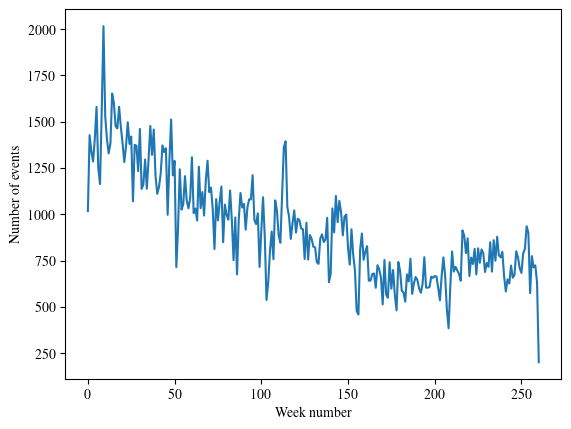

In [24]:
plt.plot(df.groupby('Timestamp').size())
## plt.ylim(0,800)
plt.xlabel('Week number')
plt.ylabel('Number of events')
plt.savefig('figures/FinDKG-full-events.pdf', bbox_inches='tight')
plt.show()

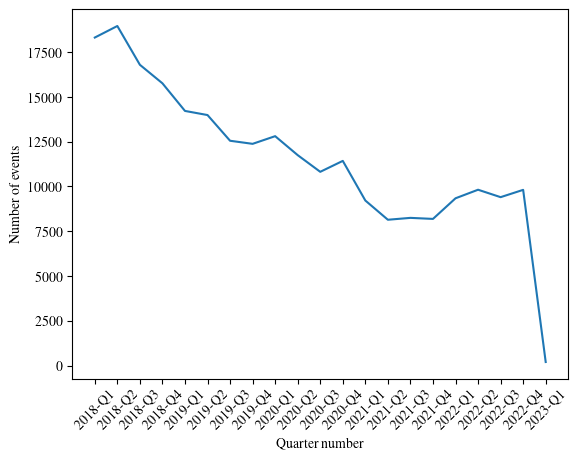

In [25]:
plt.plot(df.groupby('YearQuarter').size())
plt.xticks(np.arange(0, len(df.groupby('YearQuarter').size())), df.groupby('YearQuarter').size().index, rotation=45)
plt.xlabel('Quarter number')
plt.ylabel('Number of events')
# plt.ylim(0,8000)
plt.savefig('figures/FinDKG-full-events-quarter.pdf', bbox_inches='tight')
plt.show()

Consider only a subset of months with a sufficient number of events.

In [26]:
# Count how many times each 'YearQuarter' occurs
count = df['YearQuarter'].value_counts()
# Calculate edge density per month
subset_times = np.sort(list(count[count > 5000].index))
# Filter out the rows with 'YearQuarter' not in subset_times
df = df[df['YearQuarter'].isin(subset_times)]
# Number of time points
T = len(subset_times)
## Map 'YearQuarter' to integers based on the alphabetical order
map_year_quarter = {yq: i for i, yq in enumerate(sorted(df['YearQuarter'].unique()))}

In [27]:
# Remove all entities observed less than 10 times
count = df['Source Entity'].value_counts() + df['Target Entity'].value_counts()
entities = count.index ##count[count > 10].index
# Filter out the rows with 'Source Entity' and 'Target Entity' not in entities
df = df[df['Source Entity'].isin(entities) & df['Target Entity'].isin(entities)]
# Number of entities
N = len(entities)
## Map entities to integers based on the alphabetical order
map_entity = {e: i for i, e in enumerate(sorted(entities))}
## Use the mapping in the DF
df['Source Entity'] = df['Source Entity'].map(map_entity)
df['Target Entity'] = df['Target Entity'].map(map_entity)

Construct adjacency matrices for each pair `(Event Type, Month)`. 

In [28]:
from scipy.sparse import csr_matrix

# Create the dictionary to hold the sparse matrices
A_dict = {}

# Loop over the unique combinations
for t, event_quarter_id in enumerate(subset_times):
    for event_type_id in range(K):
        # Filter the DataFrame for the current combination
        filtered_df = df[(df['YearQuarter'] == event_quarter_id) & (df['Relation'] == event_type_id)]
        # Create a pivot table
        rows = list(filtered_df['Source Entity'])
        columns = list(filtered_df['Target Entity'])
        values = [1.] * len(filtered_df)
        # Convert the pivot table to a sparse matrix
        sparse_matrix = csr_matrix((values, (rows, columns)), shape=(N, N))
        # Add the sparse matrix to the dictionary
        A_dict[(event_type_id, t)] = sparse_matrix 

Calculate the DUASE from the adjacency matrices, using the function `duase` in `dmprdpg`. 

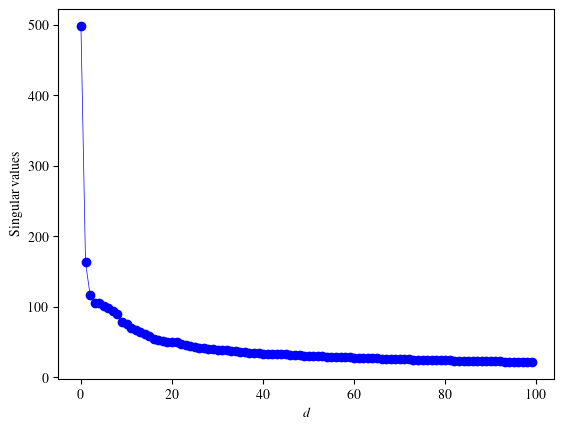

In [29]:
S = dmprdpg.singular_values_A_tilde(A_dict, K=K, T=T, d_max=100)
plt.plot(S, color='blue', marker='o', lw=0.5)
plt.xlabel('\r$d$')
plt.ylabel('Singular values')
plt.show()

In [30]:
d = dmprdpg.eigengap(S, x=3)[-1]
print(f'Estimated dimension: {d}')
X, Y = dmprdpg.duase(A_dict, K=K, T=T, d=d)

Estimated dimension: 9


Apply the `isomirror` function on the left embedding $\hat{\mathbf{X}}^k,\ k=1,\dots,K$, and plot.

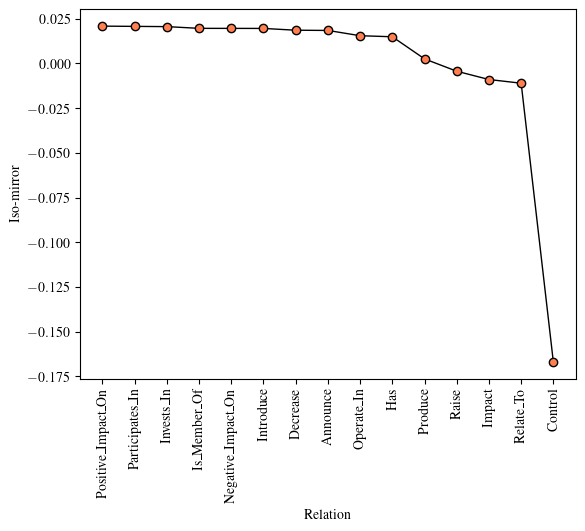

In [31]:
V = dmprdpg.mirror(X, n_components_cmds=2, n_components_isomap=1, verbose=False)
V_vals = np.sort(V[:,0])[::-1]
V_keys = np.array(map_relation[0][np.argsort(V[:,0])[::-1]])
plt.plot(np.arange(K), V_vals, marker='o', color='black', lw=1, markerfacecolor='coral')
# Plot in the legend 
plt.xticks(np.arange(K), labels=V_keys, rotation=90)
# Set xlabel and ylabel
plt.xlabel('Relation')
plt.ylabel('Iso-mirror')
## Save as PDF
plt.savefig('figures/findkg_isomap_event_types.pdf', bbox_inches='tight')
plt.show()

Repeat for the right embedding $\hat{\mathbf{Y}}^t,\ t=1,\dots,T$, and plot.

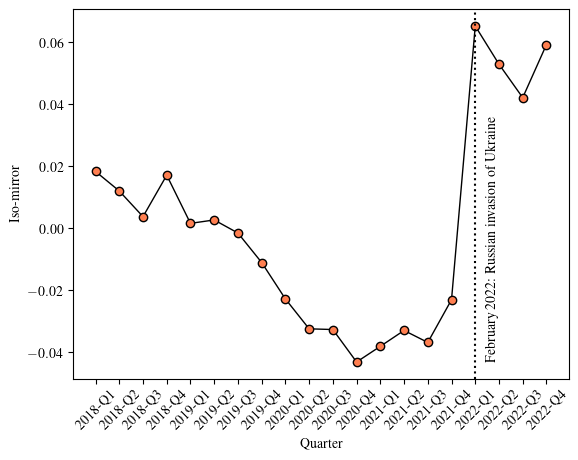

In [32]:
V = dmprdpg.mirror(Y, n_components_cmds=2, n_components_isomap=1, verbose=False)
plt.plot(np.arange(len(V))+1, V, marker='o', color='black', markerfacecolor='coral', lw=1)
plt.xticks(np.arange(len(V))+1, labels=list(map_year_quarter.keys()), rotation=45)
# Set xlabel and ylabel
plt.xlabel('Quarter')
plt.ylabel('Iso-mirror')
# Add vertical dotted line in Q1 2022 for Russian invasion of Ukraine
plt.axvline(x=map_year_quarter['2022-Q1']+1, color='black', linestyle='dotted') 
# Add text for the vertical line
plt.text(map_year_quarter['2022-Q1']+1.45, np.min(V), 'February 2022: Russian invasion of Ukraine', rotation=90, verticalalignment='bottom')
## Save as PDF
plt.savefig('figures/findkg_isomap_time.pdf', bbox_inches='tight')
plt.show()

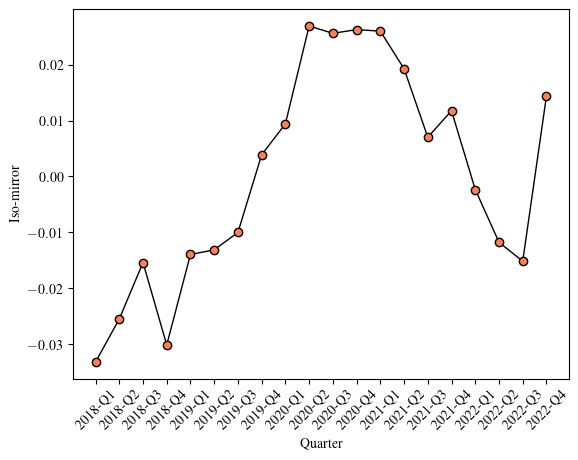

In [33]:
## Filter all entries with relation 1 (Control)
df_control = df[df['Relation'] == 1]
len(df_control) / len(df) * 100
## Construct A_dict for the control relation
A_dict_control = {}
for t, event_quarter_id in enumerate(subset_times):
    # Filter the DataFrame for the current combination
    filtered_df = df_control[df_control['YearQuarter'] == event_quarter_id]
    # Create a pivot table
    rows = list(filtered_df['Source Entity'])
    columns = list(filtered_df['Target Entity'])
    values = [1.] * len(filtered_df)
    # Convert the pivot table to a sparse matrix
    sparse_matrix = csr_matrix((values, (rows, columns)), shape=(N, N))
    # Add the sparse matrix to the dictionary
    A_dict_control[(0, t)] = sparse_matrix

## Repeat the analysis for the control relation to obtain the ISOMIRROR only for that graph with d=9
X_c, Y_c = dmprdpg.duase(A_dict_control, K=1, T=T, d=9)
V_c = dmprdpg.mirror(Y_c, n_components_cmds=2, n_components_isomap=1, verbose=False)
plt.plot(np.arange(len(V_c))+1, V_c, marker='o', color='black', markerfacecolor='coral', lw=1)
plt.xticks(np.arange(len(V_c))+1, labels=list(map_year_quarter.keys()), rotation=45)
# Set xlabel and ylabel
plt.xlabel('Quarter')
plt.ylabel('Iso-mirror')
plt.show()


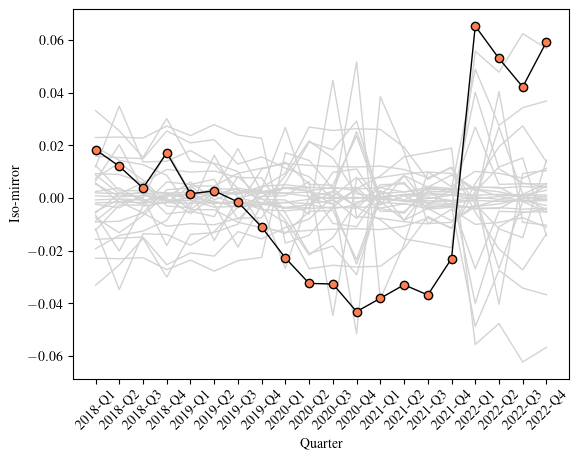

In [34]:
## Repeat the analysis above separately for all relation types
V_dict = {}
for k in range(K):
    # Filter the DataFrame for the current combination
    df_relation = df[df['Relation'] == k]
    # Construct A_dict for the current relation type
    A_dict_k = {}
    for t, event_quarter_id in enumerate(subset_times):
        # Filter the DataFrame for the current combination
        filtered_df = df_relation[df_relation['YearQuarter'] == event_quarter_id]
        # Create a pivot table
        rows = list(filtered_df['Source Entity'])
        columns = list(filtered_df['Target Entity'])
        values = [1.] * len(filtered_df)
        # Convert the pivot table to a sparse matrix
        sparse_matrix = csr_matrix((values, (rows, columns)), shape=(N, N))
        # Add the sparse matrix to the dictionary
        A_dict_k[(0, t)] = sparse_matrix
    # Repeat the analysis for the current relation type to obtain the ISOMIRROR only for that graph with d=9
    X_k, Y_k = dmprdpg.duase(A_dict_k, K=1, T=T, d=9)
    V_k = dmprdpg.mirror(Y_k, n_components_cmds=2, n_components_isomap=1, verbose=False)
    V_dict[k] = V_k

## Plot the Iso-mirror for all relation types
for k in range(K):
    plt.plot(np.arange(len(V_dict[k]))+1, V_dict[k], lw=1, c='lightgrey')
    plt.plot(np.arange(len(V_dict[k]))+1, -V_dict[k], lw=1, c='lightgrey')
plt.xticks(np.arange(len(V_dict[k]))+1, labels=list(map_year_quarter.keys()), rotation=45)
# Set xlabel and ylabel
plt.xlabel('Quarter')
plt.ylabel('Iso-mirror')
# Plot the global Iso-mirror on top
plt.plot(np.arange(len(V))+1, V, marker='o', color='black', lw=1, markerfacecolor='coral')
plt.show()


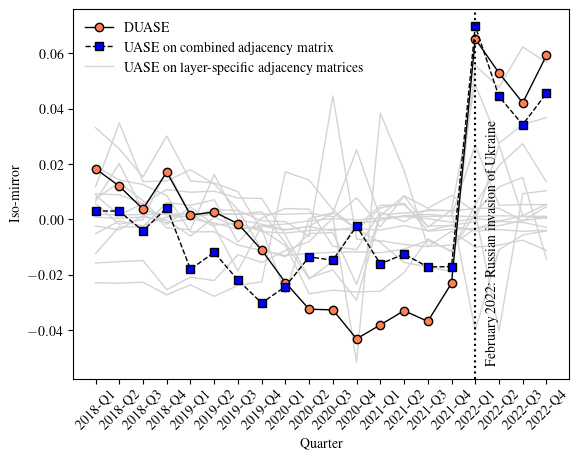

In [35]:
## Calculate the Iso-mirror from the COMBINED adjacency matrix
A_dict_combined = {}
for t, event_quarter_id in enumerate(subset_times):
    # Filter the DataFrame for the current combination
    filtered_df = df[df['YearQuarter'] == event_quarter_id]
    # Create a pivot table
    rows = list(filtered_df['Source Entity'])
    columns = list(filtered_df['Target Entity'])
    values = [1.] * len(filtered_df)
    # Convert the pivot table to a sparse matrix
    sparse_matrix = csr_matrix((values, (rows, columns)), shape=(N, N))
    # Add the sparse matrix to the dictionary
    A_dict_combined[(0, t)] = sparse_matrix

X_combined, Y_combined = dmprdpg.duase(A_dict_combined, K=1, T=T, d=9)
V_combined = dmprdpg.mirror(Y_combined, n_components_cmds=2, n_components_isomap=1, verbose=False)

## Plot the Iso-mirror for all relation types
for k in range(K):
    if np.mean(np.abs(-V_dict[k] - V)) > np.mean(np.abs(-V_dict[k] + V)):
        plt.plot(np.arange(len(V_dict[k]))+1, V_dict[k], lw=1, c='lightgrey')
    else:
        plt.plot(np.arange(len(V_dict[k]))+1, -V_dict[k], lw=1, c='lightgrey')
plt.xticks(np.arange(len(V_dict[k]))+1, labels=list(map_year_quarter.keys()), rotation=45)

# Set xlabel and ylabel
plt.xlabel('Quarter')
plt.ylabel('Iso-mirror')
# Plot the global Iso-mirror on top
plt.plot(np.arange(len(V))+1, V, marker='o', color='black', lw=1, markerfacecolor='coral', label='DUASE')
plt.plot(np.arange(len(V_combined))+1, -V_combined, marker='s', color='black', markerfacecolor='blue', lw=1, label='UASE on combined adjacency matrix', ls='dashed')
# Plot something empty to make the legend appear
plt.plot([], [], lw=1, c='lightgray', label='UASE on layer-specific adjacency matrices')
# Add legend
plt.legend(frameon=False, loc='upper left')
# Add vertical dotted line in Q1 2022 for Russian invasion of Ukraine
plt.axvline(x=map_year_quarter['2022-Q1']+1, color='black', linestyle='dotted') 
# Add text for the vertical line
plt.text(map_year_quarter['2022-Q1']+1.45, np.min(V)-0.01, 'February 2022: Russian invasion of Ukraine', rotation=90, verticalalignment='bottom')

## Save as PDF
plt.savefig('figures/findkg_isomap_time_compared.pdf', bbox_inches='tight')
plt.show()

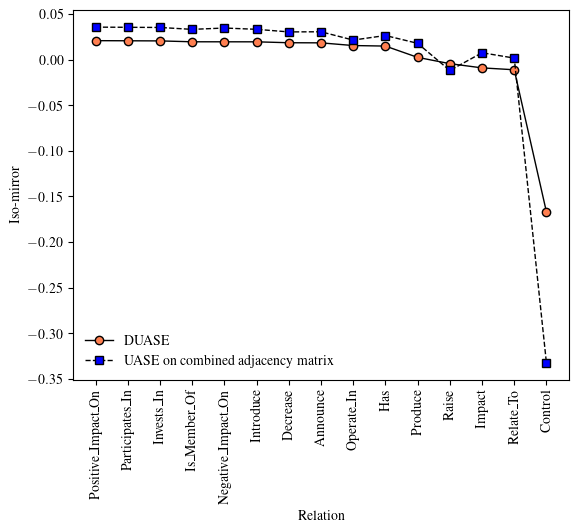

In [43]:
## Repeat on the left embedding for the combined adjacency matrix
## Calculate the Iso-mirror from the COMBINED adjacency matrix
A_dict_combined = {}
for k in range(K):
    # Filter the DataFrame for the current combination
    filtered_df = df[df['Relation'] == k]
    # Create a pivot table
    rows = list(filtered_df['Source Entity'])
    columns = list(filtered_df['Target Entity'])
    values = [1.] * len(filtered_df)
    # Convert the pivot table to a sparse matrix
    sparse_matrix = csr_matrix((values, (rows, columns)), shape=(N, N))
    # Add the sparse matrix to the dictionary
    A_dict_combined[(k, 0)] = sparse_matrix

X_combined, Y_combined = dmprdpg.duase(A_dict_combined, K=K, T=1, d=9)
V_combined = dmprdpg.mirror(X_combined, n_components_cmds=2, n_components_isomap=1, verbose=False)

V = dmprdpg.mirror(X, n_components_cmds=2, n_components_isomap=1, verbose=False)
vv = np.argsort(V[:,0])[::-1]
V_keys = np.array(map_relation[0][vv])

plt.plot(np.arange(K), V[:,0][vv], marker='o', color='black', lw=1, markerfacecolor='coral', label='DUASE')
plt.plot(np.arange(K), V_combined[:,0][vv], marker='s', color='black', lw=1, markerfacecolor='blue', ls='dashed', label='UASE on combined adjacency matrix')
# Plot in the legend
plt.xticks(np.arange(K), labels=V_keys, rotation=90)
# Set xlabel and ylabel
plt.xlabel('Relation')
plt.ylabel('Iso-mirror')
## Add legend to the bottom left
plt.legend(frameon=False, loc='lower left')
## Save as PDF
plt.savefig('figures/findkg_isomap_event_types_compared.pdf', bbox_inches='tight')
